# LWS Visits Proportion Analysis
We use Hierarchical Bayesian Modeling (HBM) to check if `trial category` (BW / NOISE / COLOR), `target category` (Animal Face / Animal Body / Human Face / Human Body / Inanimate Handmade / Inanimate Natural) has an effect on the probability of **Looking without Seeing**.

In [1]:
import time
from itertools import product

import numpy as np
import bambi as bmb
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import expit
import plotly.io as pio

import config as cnfg

pio.renderers.default = "notebook"      # or "browser"

In [2]:
VERBOSE = True
EVENT_TYPE, FUNNEL_TYPE = "visit", "lws"
INITIAL_STEP = "instance_on_target"
SEED = 42

if FUNNEL_TYPE == "lws":
    STEPS = cnfg.LWS_FUNNEL_STEPS
elif FUNNEL_TYPE == "target_return":
    STEPS = cnfg.TARGET_RETURN_FUNNEL_STEPS
else:
    raise NotImplementedError(f"Unknown FUNNEL_TYPE: {FUNNEL_TYPE}")

### Apply the Funnel
The funnel starts with all identified `events` (fixations/visits) in the dataset, and applies a series of steps to filter them down to those that meet specific criteria: excluding events from invalid trials, removing outlier events and events that do not fall on a target `icon`. Then, we apply additional steps based on the `funnel type` (LWS or TR) to further refine the events.

In [3]:
from funnel.prepare import prepare_funnel

DATA = prepare_funnel(
    data_dir=cnfg.OUTPUT_PATH,
    funnel_type=FUNNEL_TYPE,
    event_type=EVENT_TYPE,
    verbose=VERBOSE,
)

print(f"Empirical probability that a {EVENT_TYPE} is LWS given it passed the initial step `{INITIAL_STEP}`:\t{100 * DATA['final'].sum() / DATA[INITIAL_STEP].sum() :.2f}%")

Calculating Funnel Steps: 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]
C:\Users\nirjo\Documents\University\PhD\Projects\LWSv1\funnel\prepare.py:222: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Applying Funnel: 100%|██████████| 1396/1396 [00:07<00:00, 195.42it/s]


Empirical probability that a visit is LWS given it passed the initial step `instance_on_target`:	26.17%


In [4]:
from funnel.visualizations.step_size import step_sizes_figure

fig = step_sizes_figure(
    DATA, "all", "final",
    title=f"{"LWS" if FUNNEL_TYPE == "lws" else "Target Return"} Funnel: {EVENT_TYPE.capitalize()}s",
    show_individuals=True
)
fig.show()

C:\Users\nirjo\Documents\University\PhD\Projects\LWSv1\funnel\visualizations\step_size.py:34: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



### Subset the Funnel
We only care about `events` that pass the `INITIAL_STEP` defined above. We can subset the funnel and check the sub-funnel sizes.

In [5]:
SUBSET = DATA[DATA[INITIAL_STEP]]

fig = step_sizes_figure(
    SUBSET, INITIAL_STEP, "final",
    title=f"{"LWS" if FUNNEL_TYPE == "lws" else "Target Return"} Funnel: {EVENT_TYPE.capitalize()}s",
    show_individuals=True
)
fig.show()

C:\Users\nirjo\Documents\University\PhD\Projects\LWSv1\funnel\visualizations\step_size.py:34: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



### Visualize Predictors
We visualize the proportion of events that passed the`"final"` funnel step, out of all events that passed the `INITIAL_STEP`. We group data by two predictor variables: `trial category` and `target category`.

In [6]:
from funnel.prepare import calculate_funnel_sizes

STEP_SIZES = calculate_funnel_sizes(DATA, steps=STEPS, verbose=VERBOSE)

C:\Users\nirjo\Documents\University\PhD\Projects\LWSv1\funnel\prepare.py:25: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

Calculating Funnel Sizes: 100%|██████████| 1396/1396 [00:01<00:00, 720.90it/s]


#### (1) Trial Category Main Effect

In [7]:
from funnel.proportion import calculate_proportions
from funnel.visualizations.category_comparison import category_comparison_figure

prop_by_trial = calculate_proportions(
    STEP_SIZES,
    nominator="final",
    denominator=INITIAL_STEP,
    aggregate_by="trial_category",
    per_subject=True,
)

fig = category_comparison_figure(
    prop_by_trial,
    categ_col="trial_category",
    title=f"{"LWS" if FUNNEL_TYPE == "lws" else "Target Return"} {EVENT_TYPE.capitalize()} Proportions by Trial Category",
    show_distributions=True,
    show_individuals=True,
    show_mean=True,
)
fig.show()

C:\Users\nirjo\Documents\University\PhD\Projects\LWSv1\funnel\proportion.py:44: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\nirjo\Documents\University\PhD\Projects\LWSv1\funnel\proportion.py:55: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



#### (2) Target Category Main Effect

In [8]:
prop_by_target = calculate_proportions(
    STEP_SIZES,
    nominator="final",
    denominator=INITIAL_STEP,
    aggregate_by="target_category",
    per_subject=True,
)

fig = category_comparison_figure(
    prop_by_target,
    categ_col="target_category",
    title=f"{"LWS" if FUNNEL_TYPE == "lws" else "Target Return"} {EVENT_TYPE.capitalize()} Proportions by Target Category",
    show_distributions=True,
    show_individuals=True,
    show_mean=True,
)
fig.show()

C:\Users\nirjo\Documents\University\PhD\Projects\LWSv1\funnel\proportion.py:44: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\nirjo\Documents\University\PhD\Projects\LWSv1\funnel\proportion.py:55: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



### Hierarchical Bayesian Model
We use the [BAMBI package](https://bambinos.github.io/bambi/) to fit a hierarchical Bayesian logistic regression model (_logit HBM_) to the data, predicting the probability that an event that has passed the `INITIAL_STEP` will also pass all subsequent steps in the funnel (specifically, the `"final"` step), as a function of `trial category` and `target category`.

#### (1) Simple Model
In the simpler model, we only include random intercepts for each subject to account for individual differences.<br>
Our model formula is:
$$ logit(final) \sim 1 + C(trial\_category) * C(target\_category) + (1 | subject) $$

In [9]:
start = time.time()

simple_formula = "final ~ trial_category * target_category + (1 | subject)"
simple_model = bmb.Model(simple_formula, SUBSET, family="bernoulli")
simple_idata = simple_model.fit(
    draws=2000, tune=1000, chains=4, cores=2, target_accept=0.95, progressbar=False, random_seed=SEED,
)
simple_elapsed = time.time() - start
print(f"Model fitting completed in {int(simple_elapsed // 3600)}:{int((simple_elapsed % 3600) // 60)}:{simple_elapsed % 60:.2f} (hh:mm:ss)")

Modeling the probability that final==1
Initializing NUTS using jitter+adapt_diag...
C:\Users\nirjo\Documents\University\PhD\Projects\LWSv1\.venv\Lib\site-packages\pytensor\link\c\cmodule.py:2986: UserWarning:

PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library

Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Intercept, trial_category, target_category, trial_category:target_category, 1|subject_sigma, 1|subject_offset]
Sampling 4 chains for 1_000 tune and 2_

Model fitting completed in 0:1:56.81 (hh:mm:ss)


##### Model Results

In [10]:
az.summary(
    simple_idata,
    var_names=["Intercept", "trial_category", "target_category", "trial_category:target_category"]
)

mean     sd  hdi_3%  \
Intercept                                          -0.882  0.211  -1.287   
trial_category[BW]                                  0.506  0.241   0.069   
trial_category[NOISE]                              -0.091  0.225  -0.496   
target_category[HUMAN_OTHER]                       -0.090  0.242  -0.543   
target_category[ANIMAL_FACE]                        0.137  0.252  -0.362   
target_category[HUMAN_FACE]                        -0.299  0.238  -0.746   
target_category[OBJECT_HANDMADE]                   -1.095  0.308  -1.682   
target_category[OBJECT_NATURAL]                    -0.819  0.266  -1.304   
trial_category:target_category[BW, HUMAN_OTHER]    -0.122  0.328  -0.720   
trial_category:target_category[BW, ANIMAL_FACE]    -0.304  0.353  -0.930   
trial_category:target_category[BW, HUMAN_FACE]     -0.616  0.337  -1.247   
trial_category:target_category[BW, OBJECT_HANDM...  0.466  0.384  -0.257   
trial_category:target_category[BW, OBJECT_NATURAL]  0.191  0.373  -0.512   
trial_category:target_category[NOISE, HUMAN_OTHER]  0.273  0.320  -0.303   
trial_category:target_category[NOISE, ANIMAL_FACE]  0.172  0.343  -0.480   
trial_category:target_category[NOISE, HUMAN_FACE]   0.206  0.326  -0.409   
trial_category:target_category[NOISE, OBJECT_HA...  0.193  0.407  -0.540   
trial_category:target_category[NOISE, OBJECT_NA...  0.117  0.362  -0.554   

                                                    hdi_97%  mcse_mean  \
Intercept                                            -0.501      0.003   
trial_category[BW]                                    0.987      0.004   
trial_category[NOISE]                                 0.342      0.004   
target_category[HUMAN_OTHER]                          0.362      0.003   
target_category[ANIMAL_FACE]                          0.581      0.004   
target_category[HUMAN_FACE]                           0.146      0.003   
target_category[OBJECT_HANDMADE]                     -0.541      0.004   
target_category[OBJECT_NATURAL]                      -0.302      0.004   
trial_category:target_category[BW, HUMAN_OTHER]       0.513      0.005   
trial_category:target_category[BW, ANIMAL_FACE]       0.388      0.005   
trial_category:target_category[BW, HUMAN_FACE]        0.010      0.005   
trial_category:target_category[BW, OBJECT_HANDM...    1.167      0.005   
trial_category:target_category[BW, OBJECT_NATURAL]    0.896      0.005   
trial_category:target_category[NOISE, HUMAN_OTHER]    0.907      0.004   
trial_category:target_category[NOISE, ANIMAL_FACE]    0.807      0.005   
trial_category:target_category[NOISE, HUMAN_FACE]     0.818      0.005   
trial_category:target_category[NOISE, OBJECT_HA...    0.966      0.005   
trial_category:target_category[NOISE, OBJECT_NA...    0.795      0.005   

                                                    mcse_sd  ess_bulk  \
Intercept                                             0.002    3860.0   
trial_category[BW]                                    0.002    3997.0   
trial_category[NOISE]                                 0.002    3788.0   
target_category[HUMAN_OTHER]                          0.002    5003.0   
target_category[ANIMAL_FACE]                          0.003    5129.0   
target_category[HUMAN_FACE]                           0.002    4742.0   
target_category[OBJECT_HANDMADE]                      0.003    5433.0   
target_category[OBJECT_NATURAL]                       0.003    5533.0   
trial_category:target_category[BW, HUMAN_OTHER]       0.003    5036.0   
trial_category:target_category[BW, ANIMAL_FACE]       0.004    5762.0   
trial_category:target_category[BW, HUMAN_FACE]        0.003    5304.0   
trial_category:target_category[BW, OBJECT_HANDM...    0.004    5369.0   
trial_category:target_category[BW, OBJECT_NATURAL]    0.004    5860.0   
trial_category:target_category[NOISE, HUMAN_OTHER]    0.003    5167.0   
trial_category:target_category[NOISE, ANIMAL_FACE]    0.004    5102.0   
trial_category:target_category[NO

##### Model Diagnostics

C:\Users\nirjo\AppData\Local\Temp\ipykernel_5332\3105838637.py:4: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



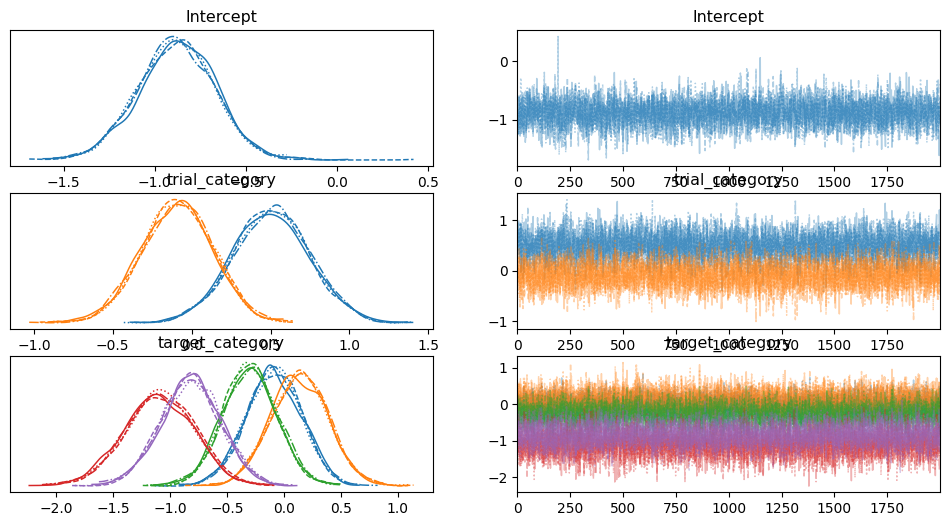

In [11]:
axes = az.plot_trace(simple_idata, var_names=["Intercept", "trial_category", "target_category"])

fig = axes.ravel()[0].figure
fig.show()

##### Model Posterior Visualization

C:\Users\nirjo\AppData\Local\Temp\ipykernel_5332\4177918318.py:4: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



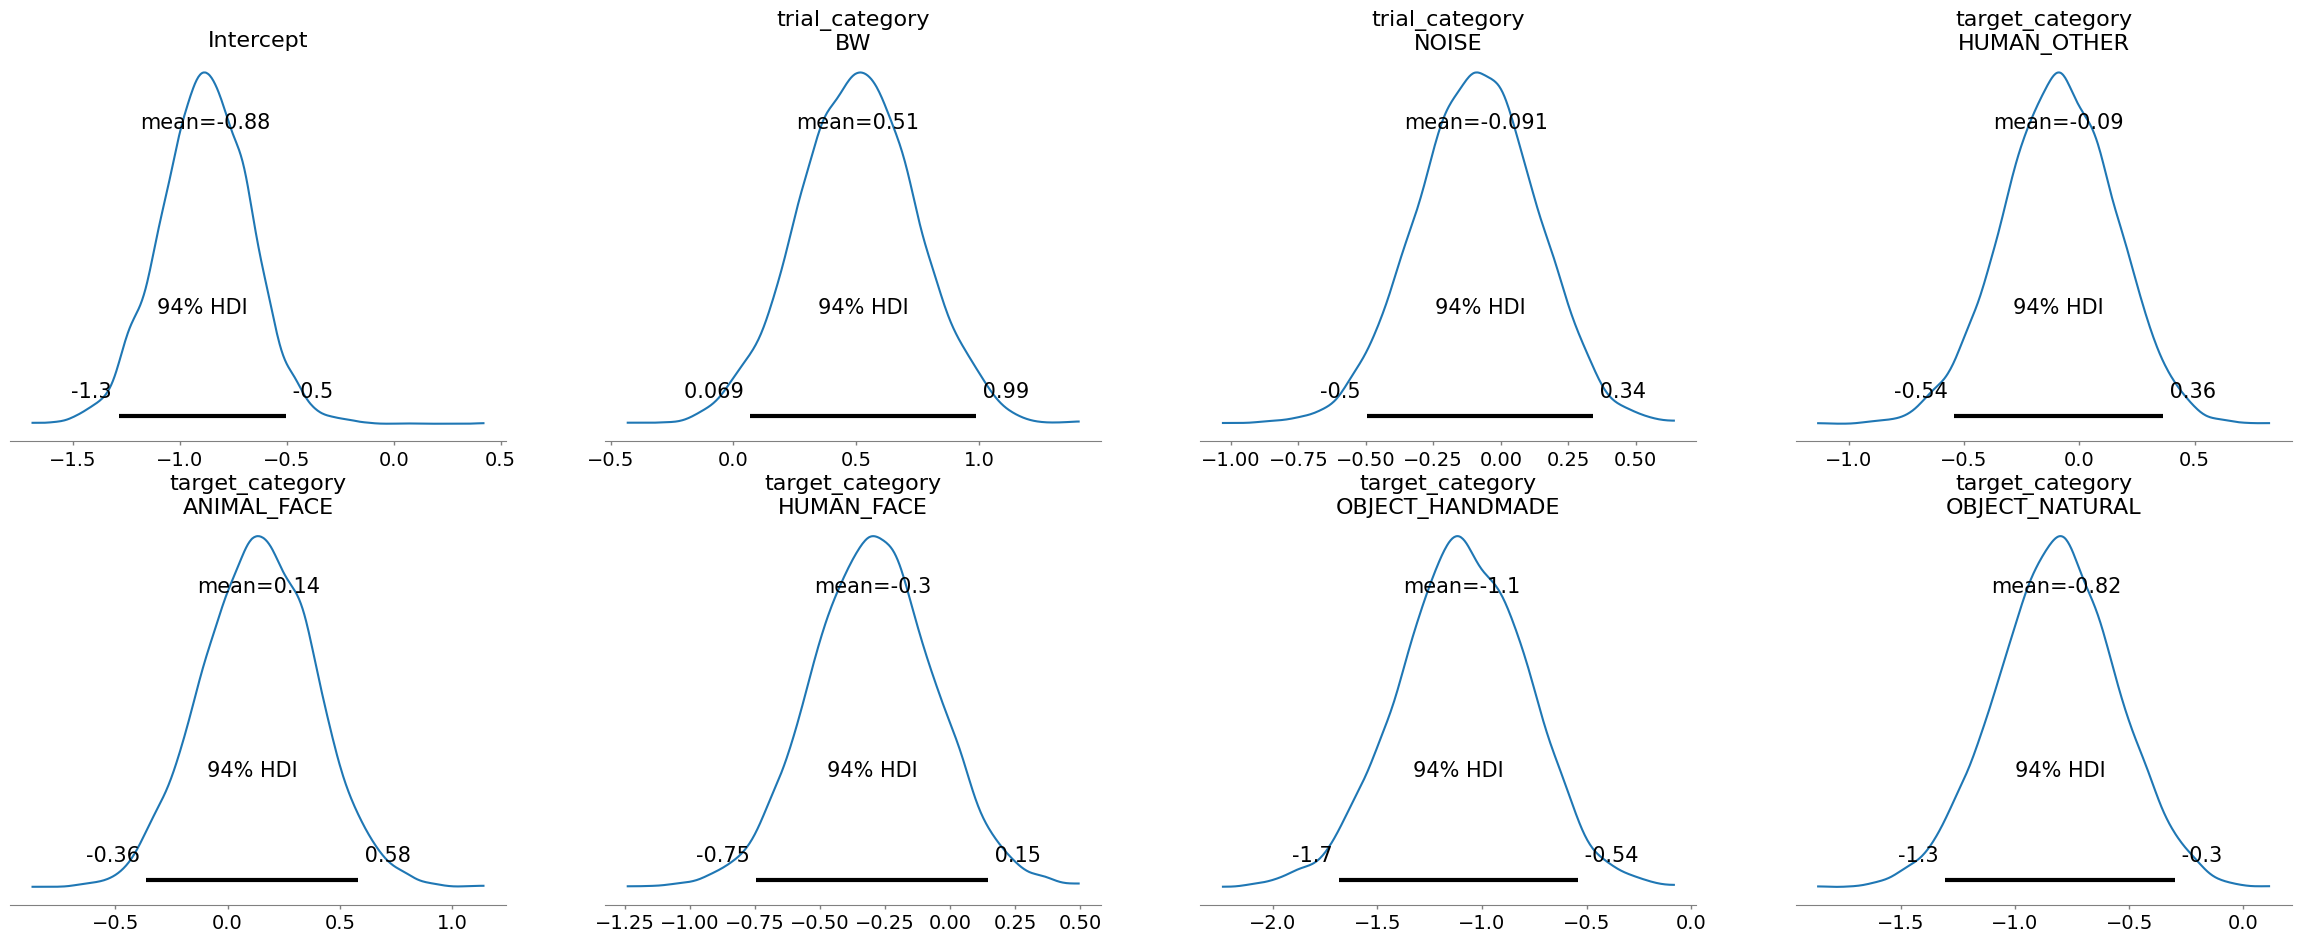

In [12]:
axes = az.plot_posterior(simple_idata, var_names=["Intercept", "trial_category", "target_category"],)

fig = axes.ravel()[0].figure
fig.show()

##### Posterior Contrasts Scores Distribution
For each level in the predictors (`trial_category` and `target_category`) we calculate the posterior success probability ($p[final==1|\hat\theta_{factor}]$), averaged over all subjects and all levels of the other factor.

In [13]:
predictors = ["subject", "trial_category", "target_category"]
new_data = pd.DataFrame(product(*[SUBSET[pred].unique() for pred in predictors]), columns=predictors)
posterior_predictions_idata = simple_model.predict(idata=simple_idata, data=new_data, kind="response", inplace=False)
posterior_predictions = posterior_predictions_idata["posterior_predictive"]["final"]    # (n_cores, n_draws, n_predictors), e.g. (4, 1000, 216)

<b>Trial Category</b>

In [14]:
column = "trial_category"
sorted_categories = pd.Series(new_data[column].unique()).astype(SUBSET[column].dtype).sort_values()
trial_category_marginals = dict()
for cat in sorted_categories:
    idx = (new_data[column] == cat).values
    predictions = np.array(posterior_predictions[:, :, idx]).flatten()
    mean, std = predictions.mean(), predictions.std()
    sem = std / np.sqrt(len(predictions))
    trial_category_marginals[cat] = (mean, std, predictions)
    print(f"{column.replace("_", " ").capitalize()}:\t{cat}\tp[final]={100*mean:.1f}±{100*std:.1f}%")

Trial category:	COLOR	p[final]=23.7±42.5%
Trial category:	BW	p[final]=31.8±46.6%
Trial category:	NOISE	p[final]=24.9±43.3%


<b>Trarget Category</b>

In [15]:
column = "target_category"
sorted_categories = pd.Series(new_data[column].unique()).astype(SUBSET[column].dtype).sort_values()
target_category_marginals = dict()
for cat in sorted_categories:
    idx = (new_data["target_category"] == cat).values
    predictions = np.array(posterior_predictions[:, :, idx]).flatten()
    mean, std = predictions.mean(), predictions.std()
    sem = std / np.sqrt(len(predictions))
    target_category_marginals[cat] = (mean, std, predictions)
    print(f"Target Category:\t{cat}\tp[final]={100*mean:.1f}±{100*std:.1f}%")

Target Category:	ANIMAL_OTHER	p[final]=32.8±46.9%
Target Category:	HUMAN_OTHER	p[final]=31.7±46.5%
Target Category:	ANIMAL_FACE	p[final]=34.6±47.6%
Target Category:	HUMAN_FACE	p[final]=24.0±42.7%
Target Category:	OBJECT_HANDMADE	p[final]=18.0±38.4%
Target Category:	OBJECT_NATURAL	p[final]=19.9±39.9%


##### Posterior Contrasts
for each pair of levels in the predictors (`trial_category` and `target_category`) we compute the posterior contrast (difference) in `log-odds` scale. We then plot the distribution over each contrast of interest.<br>
NOTE: the posterior object implicitly stores contrasts against the baseline level for each factor (`COLOR` for `trial_category`; `ANIMAL_OTHER` for `target_category`), so these do not need to be computed.

In [16]:
post = simple_idata.posterior
marginals = dict()
for factor in ["trial_category", "target_category"]:
    marginals[factor] = dict()
    base_level = SUBSET[factor].unique().sort_values()[0]   # all other levels are contrasted against this
    for (i, dim) in enumerate(post[factor][f"{factor}_dim"]):
        level = str(np.array(dim))
        if level == base_level:
            raise ValueError(f"base level {base_level} matches contrasted level {level} for factor {factor}.")
        name = f"{level}_minus_{base_level}"
        log_odds = post[factor].values[:, :, i]     # (n_draws, n_chains)
        marginals[factor][name] = log_odds

<b>Trial Category</b>

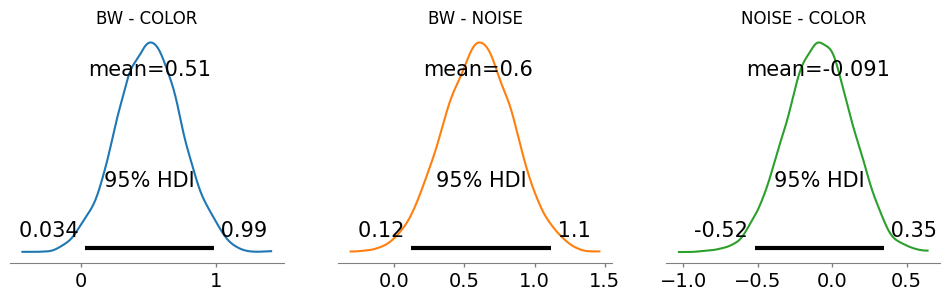

In [17]:
marginals['trial_category']['BW_minus_NOISE'] = marginals['trial_category']['BW_minus_COLOR'] - marginals['trial_category']['NOISE_minus_COLOR']

interesting = sorted(marginals['trial_category'].keys())
_, axes = plt.subplots(1, len(interesting), figsize=(12, 3))
for i, contrast in enumerate(interesting):
    label=contrast.replace("_minus_", " - ").upper()
    az.plot_posterior(
        marginals['trial_category'][contrast], hdi_prob=0.95, color=f"C{i}", ax=axes[i],
        # label=label,
    )
    axes[i].set_title(label)
plt.show()

<b>Target Category</b>

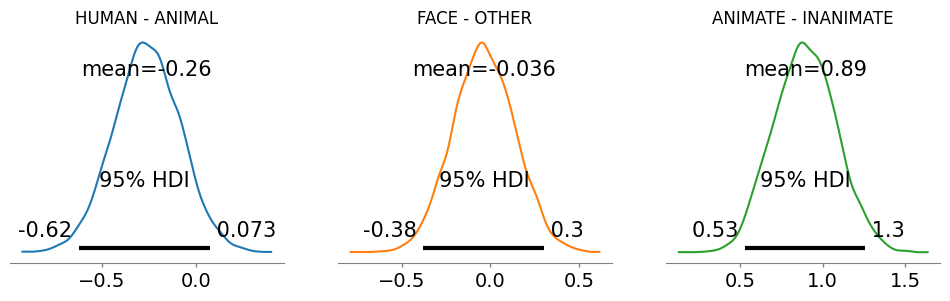

In [18]:
marginals['target_category']['HUMAN_minus_ANIMAL'] = 0.5 * (
        marginals['target_category']['HUMAN_OTHER_minus_ANIMAL_OTHER'] + marginals['target_category']['HUMAN_FACE_minus_ANIMAL_OTHER'] - marginals['target_category']['ANIMAL_FACE_minus_ANIMAL_OTHER']
)

marginals['target_category']['FACE_minus_OTHER'] = 0.5 * (
        marginals['target_category']['ANIMAL_FACE_minus_ANIMAL_OTHER'] + marginals['target_category']['HUMAN_FACE_minus_ANIMAL_OTHER'] - marginals['target_category']['HUMAN_OTHER_minus_ANIMAL_OTHER']
)

marginals['target_category']['ANIMATE_minus_INANIMATE'] = 0.25 * (
    marginals['target_category']['HUMAN_OTHER_minus_ANIMAL_OTHER'] + marginals['target_category']['ANIMAL_FACE_minus_ANIMAL_OTHER'] +
    marginals['target_category']['HUMAN_FACE_minus_ANIMAL_OTHER']
) - 0.5 * (
    marginals['target_category']['OBJECT_HANDMADE_minus_ANIMAL_OTHER'] + marginals['target_category']['OBJECT_NATURAL_minus_ANIMAL_OTHER']
)

interesting = ['HUMAN_minus_ANIMAL', 'FACE_minus_OTHER', 'ANIMATE_minus_INANIMATE']
_, axes = plt.subplots(1, len(interesting), figsize=(12, 3))
for i, contrast in enumerate(interesting):
    label=contrast.replace("_minus_", " - ").upper()
    data = marginals['target_category'][contrast]
    az.plot_posterior(
        data, hdi_prob=0.95, color=f"C{i}", ax=axes[i], # label=label,
    )
    axes[i].set_title(label)
plt.show()

In [19]:
animate_probs = expit(0.25 * (
    marginals['target_category']['HUMAN_OTHER_minus_ANIMAL_OTHER'] + marginals['target_category']['ANIMAL_FACE_minus_ANIMAL_OTHER'] +
    marginals['target_category']['HUMAN_FACE_minus_ANIMAL_OTHER']
))
inanimate_probs = expit(0.5 * (
    marginals['target_category']['OBJECT_HANDMADE_minus_ANIMAL_OTHER'] + marginals['target_category']['OBJECT_NATURAL_minus_ANIMAL_OTHER']
))
prob_diff = (animate_probs - inanimate_probs).reshape(-1)
hdi_95 = 100 * az.hdi(prob_diff, hdi_prob=0.95)
print(f"Animate Targets have {100 * prob_diff.mean() :.1f} % points more chance of error than Inanimate Targets (95% HDI: [{hdi_95[0] :.1f}, {hdi_95[1] :.1f}])].")

Animate Targets have 20.5 % points more chance of error than Inanimate Targets (95% HDI: [12.5, 27.5])].


#### (2) Complex Model
In the more complex model, we include random intercepts **and** random slopes for each subject. This will result in a better fit for subject data, by may take much longer to run. We **do not** include interaction-slopes as random (per-subject) effects, as this will result in very small sample-sizes per sub-group, and may run indefinitely.<br>
Our model formula is:
$$ logit(final) \sim 1 + C(trial\_category) * C(target\_category) + (1 + C(trial\_category) + C(target\_category) | subject) $$

In [20]:
start = time.time()

complex_formula = "final ~ trial_category * target_category + (1 + trial_category + target_category | subject)"
complex_model = bmb.Model(complex_formula, SUBSET, family="bernoulli")
complex_idata = complex_model.fit(
    draws=2000, tune=1000, chains=4, cores=2, target_accept=0.95, progressbar=False, random_seed=SEED,
)
complex_elapsed = time.time() - start
print(f"Model fitting completed in {int(complex_elapsed // 3600)}:{int((complex_elapsed % 3600) // 60)}:{complex_elapsed % 60:.2f} (hh:mm:ss)")

Modeling the probability that final==1
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Intercept, trial_category, target_category, trial_category:target_category, 1|subject_sigma, 1|subject_offset, trial_category|subject_sigma, trial_category|subject_offset, target_category|subject_sigma, target_category|subject_offset]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 311 seconds.


Model fitting completed in 0:5:16.03 (hh:mm:ss)


##### Model Results

In [21]:
az.summary(
    complex_idata,
    var_names=["Intercept", "trial_category", "target_category", "trial_category:target_category"]
)

mean     sd  hdi_3%  \
Intercept                                          -0.880  0.207  -1.266   
trial_category[BW]                                  0.503  0.253   0.027   
trial_category[NOISE]                              -0.096  0.234  -0.548   
target_category[HUMAN_OTHER]                       -0.108  0.263  -0.605   
target_category[ANIMAL_FACE]                        0.115  0.288  -0.432   
target_category[HUMAN_FACE]                        -0.315  0.251  -0.781   
target_category[OBJECT_HANDMADE]                   -1.084  0.331  -1.729   
target_category[OBJECT_NATURAL]                    -0.805  0.296  -1.369   
trial_category:target_category[BW, HUMAN_OTHER]    -0.135  0.339  -0.792   
trial_category:target_category[BW, ANIMAL_FACE]    -0.285  0.366  -1.007   
trial_category:target_category[BW, HUMAN_FACE]     -0.614  0.344  -1.259   
trial_category:target_category[BW, OBJECT_HANDM...  0.465  0.393  -0.287   
trial_category:target_category[BW, OBJECT_NATURAL]  0.168  0.392  -0.617   
trial_category:target_category[NOISE, HUMAN_OTHER]  0.270  0.327  -0.343   
trial_category:target_category[NOISE, ANIMAL_FACE]  0.194  0.350  -0.454   
trial_category:target_category[NOISE, HUMAN_FACE]   0.216  0.336  -0.415   
trial_category:target_category[NOISE, OBJECT_HA...  0.161  0.409  -0.589   
trial_category:target_category[NOISE, OBJECT_NA...  0.069  0.366  -0.612   

                                                    hdi_97%  mcse_mean  \
Intercept                                            -0.490      0.004   
trial_category[BW]                                    0.977      0.005   
trial_category[NOISE]                                 0.324      0.005   
target_category[HUMAN_OTHER]                          0.385      0.005   
target_category[ANIMAL_FACE]                          0.644      0.005   
target_category[HUMAN_FACE]                           0.167      0.005   
target_category[OBJECT_HANDMADE]                     -0.481      0.006   
target_category[OBJECT_NATURAL]                      -0.243      0.006   
trial_category:target_category[BW, HUMAN_OTHER]       0.481      0.006   
trial_category:target_category[BW, ANIMAL_FACE]       0.364      0.006   
trial_category:target_category[BW, HUMAN_FACE]        0.023      0.007   
trial_category:target_category[BW, OBJECT_HANDM...    1.195      0.007   
trial_category:target_category[BW, OBJECT_NATURAL]    0.847      0.007   
trial_category:target_category[NOISE, HUMAN_OTHER]    0.888      0.006   
trial_category:target_category[NOISE, ANIMAL_FACE]    0.867      0.006   
trial_category:target_category[NOISE, HUMAN_FACE]     0.834      0.006   
trial_category:target_category[NOISE, OBJECT_HA...    0.936      0.007   
trial_category:target_category[NOISE, OBJECT_NA...    0.766      0.006   

                                                    mcse_sd  ess_bulk  \
Intercept                                             0.003    2270.0   
trial_category[BW]                                    0.003    2206.0   
trial_category[NOISE]                                 0.003    2244.0   
target_category[HUMAN_OTHER]                          0.003    2608.0   
target_category[ANIMAL_FACE]                          0.003    2817.0   
target_category[HUMAN_FACE]                           0.003    2690.0   
target_category[OBJECT_HANDMADE]                      0.003    3198.0   
target_category[OBJECT_NATURAL]                       0.003    2886.0   
trial_category:target_category[BW, HUMAN_OTHER]       0.003    2783.0   
trial_category:target_category[BW, ANIMAL_FACE]       0.004    3627.0   
trial_category:target_category[BW, HUMAN_FACE]        0.003    2785.0   
trial_category:target_category[BW, OBJECT_HANDM...    0.004    3383.0   
trial_category:target_category[BW, OBJECT_NATURAL]    0.004    3306.0   
trial_category:target_category[NOISE, HUMAN_OTHER]    0.003    2920.0   
trial_category:target_category[NOISE, ANIMAL_FACE]    0.003    3736.0   
trial_category:target_category[NO

##### Model Diagnostics

C:\Users\nirjo\AppData\Local\Temp\ipykernel_5332\3015624268.py:4: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



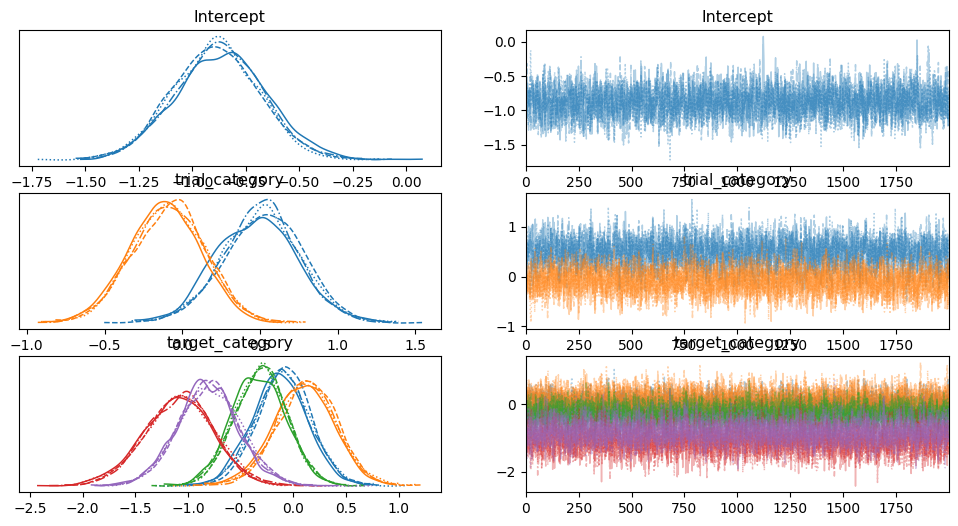

In [22]:
axes = az.plot_trace(complex_idata, var_names=["Intercept", "trial_category", "target_category"])

fig = axes.ravel()[0].figure
fig.show()

##### Model Posterior Visualization

C:\Users\nirjo\AppData\Local\Temp\ipykernel_5332\3490495720.py:4: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



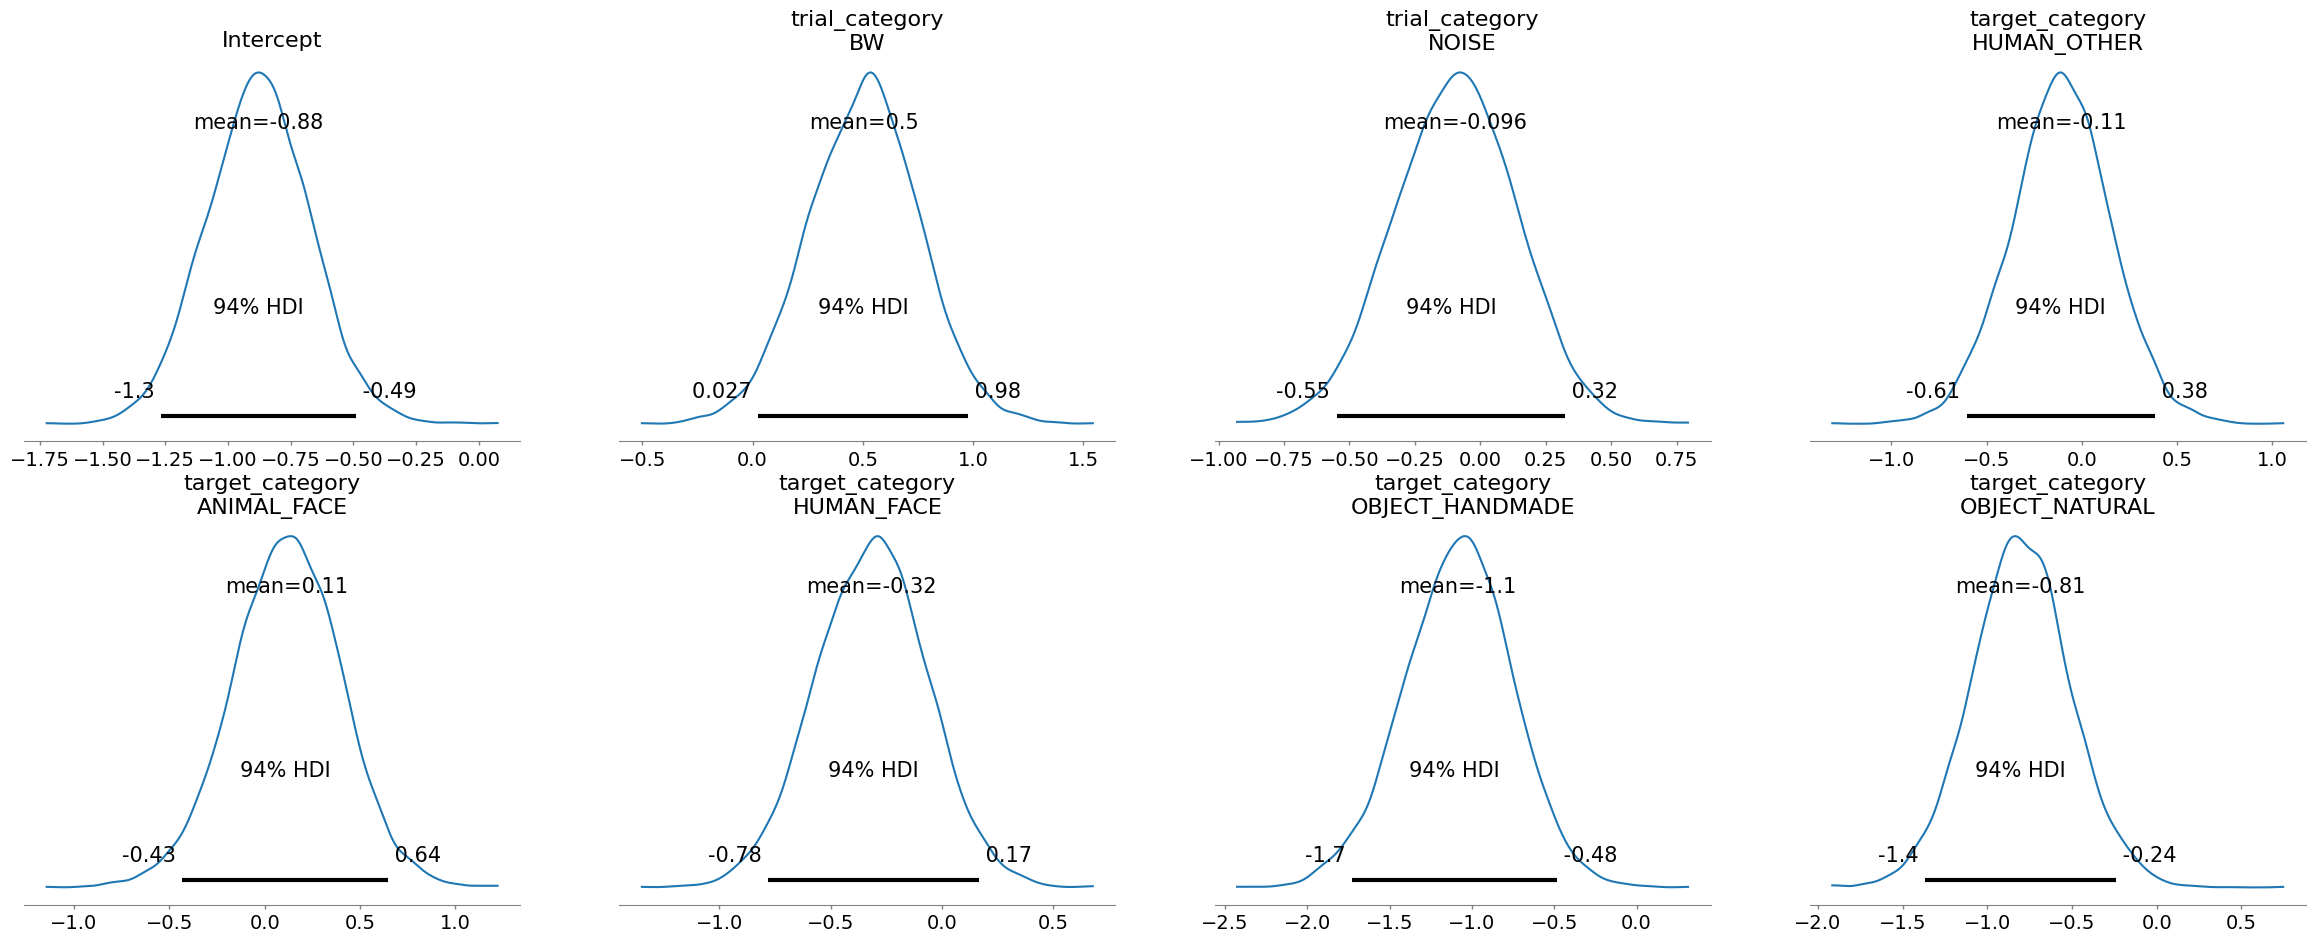

In [23]:
axes = az.plot_posterior(complex_idata, var_names=["Intercept", "trial_category", "target_category"],)

fig = axes.ravel()[0].figure
fig.show()

### Frequentist Analysis
We repeat the Bayesian analysis using a frequentist approach - applying a generalized hierarchical linear model using the _simple_ formula:
$$logit(final) \sim 1 + C(trial\_category) * C(target\_category) + (1 | subject) $$

In [24]:
import polars as pl
from pymer4.models import glmer

Error importing in API mode: ImportError('On Windows, cffi mode "ANY" is only "ABI".')
Trying to import in ABI mode.


In [25]:
model = glmer(
    formula="final ~ trial_category * target_category + (1 | subject)",
    data=pl.from_pandas(SUBSET),
    family="binomial",      # logistic regression in R uses `Binomial` (with parameter `n=1`)
)
model.set_factors({
    "subject": SUBSET["subject"].unique().sort_values().map(str, na_action="").tolist(),
    "trial_category": SUBSET["trial_category"].unique().sort_values().tolist(),
    "target_category": SUBSET["target_category"].unique().sort_values().tolist()
})
result = model.fit(summary=True, exponentiate=False)
result

GT(_tbl_data=shape: (21, 10)
┌────────────┬───────────────────┬───────────┬───────────┬───┬───────────┬──────┬──────────┬───────┐
│ rfx        ┆ param             ┆ estimate  ┆ conf_low  ┆ … ┆ z_stat    ┆ df   ┆ p_value  ┆ stars │
│ ---        ┆ ---               ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---  ┆ ---      ┆ ---   │
│ str        ┆ str               ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64  ┆ str      ┆ str   │
╞════════════╪═══════════════════╪═══════════╪═══════════╪═══╪═══════════╪══════╪══════════╪═══════╡
│ subject-sd ┆ (Intercept)       ┆ 0.299293  ┆ null      ┆ … ┆ null      ┆ null ┆ null     ┆ null  │
│ null       ┆ null              ┆ null      ┆ null      ┆ … ┆ null      ┆ null ┆ null     ┆ null  │
│ Fixed      ┆ null              ┆ null      ┆ null      ┆ … ┆ null      ┆ null ┆ null     ┆ null  │
│ Effects:   ┆                   ┆           ┆           ┆   ┆           ┆      ┆          ┆       │
│ null       ┆ (Intercept)       ┆ -0.769484 ┆ -1.239742 ┆ … ┆ -3.207088 ┆ inf  ┆ 0.001341 ┆ **    │
│ null       ┆ trial_categoryBW  ┆ 0.435141  ┆ -0.183045 ┆ … ┆ 1.379618  ┆ inf  ┆ 0.1677   ┆       │
│ …          ┆ …                 ┆ …         ┆ …         ┆ … ┆ …         ┆ …    ┆ …        ┆ …     │
│ null       ┆ trial_categoryNOI ┆ 0.355041  ┆ -0.412412 ┆ … ┆ 0.906724  ┆ inf  ┆ 0.3646   ┆       │
│            ┆ SE:target_cat…    ┆           ┆           ┆   ┆           ┆      ┆          ┆       │
│ null       ┆ trial_categoryBW: ┆ 0.700374  ┆ -0.26292  ┆ … ┆ 1.425014  ┆ inf  ┆ 0.1542   ┆       │
│            ┆ target_catego…    ┆           ┆           ┆   ┆           ┆      ┆          ┆       │
│ null       ┆ trial_categoryNOI ┆ 0.517016  ┆ -0.469641 ┆ … ┆ 1.027036  ┆ inf  ┆ 0.3044   ┆       │
│            ┆ SE:target_cat…    ┆           ┆           ┆   ┆           ┆      ┆          ┆       │
│ null       ┆ trial_categoryBW: ┆ 0.333314  ┆ -0.569894 ┆ … ┆ 0.723292  ┆ inf  ┆ 0.4695   ┆       │
│            ┆ target_catego…    ┆           ┆           ┆   ┆           ┆      ┆          ┆       │
│ null       ┆ trial_categoryNOI ┆ 0.329123  ┆ -0.517652 ┆ … ┆ 0.761795  ┆ inf  ┆ 0.4462   ┆       │
│            ┆ SE:target_cat…    ┆           ┆           ┆   ┆           ┆      ┆          ┆       │
└────────────┴───────────────────┴───────────┴───────────┴───┴───────────┴──────┴──────────┴───────┘, _body=<great_tables._gt_data.Body object at 0x00000229A9736780>, _boxhead=Boxhead([ColInfo(var='rfx', type=<ColInfoTypeEnum.default: 1>, column_label='Random Effects:', column_align='left', column_width=None), ColInfo(var='param', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None), ColInfo(var='estimate', type=<ColInfoTypeEnum.default: 1>, column_label='Estimate', column_align='right', column_width=None), ColInfo(var='conf_low', type=<ColInfoTypeEnum.default: 1>, column_label='CI-low', column_align='right', column_width=None), ColInfo(var='conf_high', type=<ColInfoTypeEnum.default: 1>, column_label='CI-high', column_align='right', column_width=None), ColInfo(var='std_error', type=<ColInfoTypeEnum.default: 1>, column_label='SE', column_align='right', column_width=None), ColInfo(var='z_stat', type=<ColInfoTypeEnum.default: 1>, column_label='Z-stat', column_align='right', column_width=None), ColInfo(var='df', type=<ColInfoTypeEnum.default: 1>, column_label='df', column_align='right', column_width=None), ColInfo(var='p_value', type=<ColInfoTypeEnum.default: 1>, column_label='p', column_align='left', column_width=None), ColInfo(var='stars', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x00000229A9736180>, _spanners=Spanners([]), _heading=Heading(title='Formula: glmer(final~trial_category*target_category+(1|subject))', subtitle=Md(text='Family: *binomial (link: *default*)*  \n            Number of observations: *2308*  \n            Confidence intervals: *parametric*  \n            -----------

##### Marginals & Contrasts
**Trial Category**

In [26]:
model.emmeans("trial_category")

R messages: 
NOTE: Results may be misleading due to involvement in interactions

R messages: 
NOTE: Results may be misleading due to involvement in interactions



shape: (3, 6)
┌────────────────┬──────────┬──────────┬─────┬───────────┬───────────┐
│ trial_category ┆ prob     ┆ SE       ┆ df  ┆ asymp_LCL ┆ asymp_UCL │
│ ---            ┆ ---      ┆ ---      ┆ --- ┆ ---       ┆ ---       │
│ cat            ┆ f64      ┆ f64      ┆ f64 ┆ f64       ┆ f64       │
╞════════════════╪══════════╪══════════╪═════╪═══════════╪═══════════╡
│ COLOR          ┆ 0.221676 ┆ 0.022088 ┆ inf ┆ 0.173417  ┆ 0.278835  │
│ BW             ┆ 0.311354 ┆ 0.026116 ┆ inf ┆ 0.25263   ┆ 0.376844  │
│ NOISE          ┆ 0.237072 ┆ 0.022043 ┆ inf ┆ 0.188497  ┆ 0.293635  │
└────────────────┴──────────┴──────────┴─────┴───────────┴───────────┘

In [27]:
model.emmeans("trial_category", contrasts="pairwise", p_adjust="tukey")

R messages: 
NOTE: Results may be misleading due to involvement in interactions

R messages: 
NOTE: Results may be misleading due to involvement in interactions



shape: (3, 9)
┌───────────────┬────────────┬──────────┬─────┬───┬───────────┬──────┬───────────┬──────────┐
│ contrast      ┆ odds_ratio ┆ SE       ┆ df  ┆ … ┆ asymp_UCL ┆ null ┆ z_ratio   ┆ p_value  │
│ ---           ┆ ---        ┆ ---      ┆ --- ┆   ┆ ---       ┆ ---  ┆ ---       ┆ ---      │
│ cat           ┆ f64        ┆ f64      ┆ f64 ┆   ┆ f64       ┆ f64  ┆ f64       ┆ f64      │
╞═══════════════╪════════════╪══════════╪═════╪═══╪═══════════╪══════╪═══════════╪══════════╡
│ COLOR / BW    ┆ 0.629943   ┆ 0.080136 ┆ inf ┆ … ┆ 0.84876   ┆ 1.0  ┆ -3.632724 ┆ 0.000819 │
│ COLOR / NOISE ┆ 0.916564   ┆ 0.116718 ┆ inf ┆ … ┆ 1.23532   ┆ 1.0  ┆ -0.684165 ┆ 0.77274  │
│ BW / NOISE    ┆ 1.454996   ┆ 0.175884 ┆ inf ┆ … ┆ 1.931537  ┆ 1.0  ┆ 3.102203  ┆ 0.005455 │
└───────────────┴────────────┴──────────┴─────┴───┴───────────┴──────┴───────────┴──────────┘

**Target Category**

In [28]:
model.emmeans("target_category")

R messages: 
NOTE: Results may be misleading due to involvement in interactions

R messages: 
NOTE: Results may be misleading due to involvement in interactions



shape: (6, 6)
┌─────────────────┬──────────┬──────────┬─────┬───────────┬───────────┐
│ target_category ┆ prob     ┆ SE       ┆ df  ┆ asymp_LCL ┆ asymp_UCL │
│ ---             ┆ ---      ┆ ---      ┆ --- ┆ ---       ┆ ---       │
│ cat             ┆ f64      ┆ f64      ┆ f64 ┆ f64       ┆ f64       │
╞═════════════════╪══════════╪══════════╪═════╪═══════════╪═══════════╡
│ ANIMAL_OTHER    ┆ 0.330902 ┆ 0.032851 ┆ inf ┆ 0.250775  ┆ 0.422203  │
│ HUMAN_OTHER     ┆ 0.313268 ┆ 0.029428 ┆ inf ┆ 0.241441  ┆ 0.395326  │
│ ANIMAL_FACE     ┆ 0.342897 ┆ 0.033262 ┆ inf ┆ 0.26138   ┆ 0.434869  │
│ HUMAN_FACE      ┆ 0.234674 ┆ 0.025167 ┆ inf ┆ 0.174973  ┆ 0.30716   │
│ OBJECT_HANDMADE ┆ 0.161303 ┆ 0.023854 ┆ inf ┆ 0.10789   ┆ 0.234217  │
│ OBJECT_NATURAL  ┆ 0.187404 ┆ 0.024307 ┆ inf ┆ 0.131595  ┆ 0.259799  │
└─────────────────┴──────────┴──────────┴─────┴───────────┴───────────┘

In [29]:
model.emmeans(
    "target_category",
    contrasts={
        "HUMAN_minus_ANIMAL": [-0.5, 0.5, -0.5, 0.5, 0, 0],
        "FACE_minus_OTHER": [-0.5, -0.5, 0.5, 0.5, 0, 0],
        "ANIMATE_minus_INANIMATE": [0.25, 0.25, 0.25, 0.25, -0.5, -0.5]
    },
    p_adjust="sidak",
    type="response",
)

R messages: 
NOTE: Results may be misleading due to involvement in interactions

R messages: 
NOTE: Results may be misleading due to involvement in interactions



shape: (3, 9)
┌─────────────────────┬────────────┬──────────┬─────┬───┬───────────┬──────┬───────────┬───────────┐
│ contrast            ┆ odds_ratio ┆ SE       ┆ df  ┆ … ┆ asymp_UCL ┆ null ┆ z_ratio   ┆ p_value   │
│ ---                 ┆ ---        ┆ ---      ┆ --- ┆   ┆ ---       ┆ ---  ┆ ---       ┆ ---       │
│ cat                 ┆ f64        ┆ f64      ┆ f64 ┆   ┆ f64       ┆ f64  ┆ f64       ┆ f64       │
╞═════════════════════╪════════════╪══════════╪═════╪═══╪═══════════╪══════╪═══════════╪═══════════╡
│ HUMAN_minus_ANIMAL  ┆ 0.736213   ┆ 0.08394  ┆ inf ┆ … ┆ 0.966577  ┆ 1.0  ┆ -2.685891 ┆ 0.021544  │
│ FACE_minus_OTHER    ┆ 0.842181   ┆ 0.096141 ┆ inf ┆ … ┆ 1.106074  ┆ 1.0  ┆ -1.504599 ┆ 0.346993  │
│ ANIMATE_minus_INANI ┆ 2.069669   ┆ 0.241627 ┆ inf ┆ … ┆ 2.735048  ┆ 1.0  ┆ 6.230491  ┆ 1.3949e-9 │
│ MATE                ┆            ┆          ┆     ┆   ┆           ┆      ┆           ┆           │
└─────────────────────┴────────────┴──────────┴─────┴───┴───────────┴──────┴───────────┴───────────┘